# Assignment 3 - Background Estimation and Motion Detection
## DMET 901 - Computer Vision
### German University in Cairo
---
This implementation uses **completely from-scratch** algorithms.

## Import Required Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import Video, display
import os

print("Libraries imported successfully!")

Libraries imported successfully!


## Helper Function: Load Video as Grayscale

In [2]:
def load_video_as_grayscale(video_path):
    """
    Load video and convert all frames to grayscale.
    This is a helper function for preprocessing.
    
    NumPy functions ARE allowed here (preprocessing stage).
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Error: Could not open video file {video_path}")
    
    # Get video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    print(f"Loading video: {video_path}")
    print(f"  - Total frames: {frame_count}")
    print(f"  - Resolution: {frame_width}x{frame_height}")
    print(f"  - FPS: {fps}")
    
    # Initialize array to store all grayscale frames
    frames = np.zeros((frame_height, frame_width, frame_count), dtype=np.uint8)
    
    frame_idx = 0
    print("Reading and converting frames to grayscale...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert to grayscale (NumPy allowed in preprocessing)
        if len(frame.shape) == 3:
            weights = np.array([0.114, 0.587, 0.299])  # BGR format
            gray_frame = np.dot(frame, weights).astype(np.uint8)
            frames[:, :, frame_idx] = gray_frame
        else:
            frames[:, :, frame_idx] = frame
        
        frame_idx += 1
        if frame_idx % 50 == 0:
            print(f"  Processed {frame_idx}/{frame_count} frames")
    
    cap.release()
    print(f"Successfully loaded {frame_idx} frames")
    
    return frames, fps

## 1. EstimateBackground Function (From Scratch)

In [3]:
def EstimateBackground(frames):
    """
    Estimate the background using median filtering.
    COMPLETELY FROM SCRATCH - No predefined NumPy functions.
    """
    height, width, num_frames = frames.shape
    
    print(f"Computing median background from {num_frames} frames...")
    print("Using manual median calculation (from scratch with quicksort)...")
    
    # Manual quicksort implementation
    def quicksort(arr, low, high):
        """Manual quicksort - completely from scratch"""
        if low < high:
            # Partition
            pivot = arr[high]
            i = low - 1
            for j in range(low, high):
                if arr[j] <= pivot:
                    i += 1
                    arr[i], arr[j] = arr[j], arr[i]
            arr[i + 1], arr[high] = arr[high], arr[i + 1]
            pi = i + 1
            
            # Recursively sort
            quicksort(arr, low, pi - 1)
            quicksort(arr, pi + 1, high)
    
    # Create output array
    background = frames[:, :, 0].copy()
    
    # Process each pixel manually
    for row in range(height):
        if (row + 1) % 100 == 0:
            print(f"  Processing row {row + 1}/{height} ({100.0 * (row + 1) / height:.1f}%)")
        
        for col in range(width):
            # Collect all pixel values across frames
            pixel_values = []
            for frame_idx in range(num_frames):
                pixel_values.append(int(frames[row, col, frame_idx]))
            
            # Manual sort using quicksort
            quicksort(pixel_values, 0, len(pixel_values) - 1)
            
            # Calculate median manually
            mid = len(pixel_values) // 2
            if len(pixel_values) % 2 == 0:
                median_value = (pixel_values[mid - 1] + pixel_values[mid]) // 2
            else:
                median_value = pixel_values[mid]
            
            background[row, col] = median_value
    
    print("Background estimation complete!")
    return background

## 2. DetectMotion Function (From Scratch)

In [4]:
def DetectMotion(frames, background_image):
    """
    Detect motion using differential motion analysis.
    COMPLETELY FROM SCRATCH - No predefined NumPy functions.
    """
    THRESHOLD = 25  # Hardcoded
    
    height, width, num_frames = frames.shape
    
    print(f"Detecting motion with threshold={THRESHOLD}")
    print(f"Processing {num_frames} frames of size {width}x{height}...")
    print("Using manual operations (from scratch)...")
    
    # Create output array
    motion_frames = frames.copy()
    
    # Process each frame
    for frame_idx in range(num_frames):
        if (frame_idx + 1) % 50 == 0:
            print(f"  Processed {frame_idx + 1}/{num_frames} frames")
        
        # Process each pixel
        for row in range(height):
            for col in range(width):
                # Get pixel values
                current_pixel = int(frames[row, col, frame_idx])
                background_pixel = int(background_image[row, col])
                
                # Manual absolute difference
                diff = current_pixel - background_pixel
                if diff < 0:
                    diff = -diff  # Manual abs()
                
                # Manual threshold comparison
                if diff > THRESHOLD:
                    motion_frames[row, col, frame_idx] = 255
                else:
                    motion_frames[row, col, frame_idx] = 0
    
    print(f"Motion detection complete! Processed {num_frames} frames")
    return motion_frames

## 3. Helper Functions for Saving

In [5]:
def save_motion_video(motion_frames, output_path, fps):
    """Save motion frames as a video file."""
    height, width, num_frames = motion_frames.shape
    
    if num_frames == 0:
        print("No frames to save!")
        return
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=False)
    
    print(f"Saving motion video to {output_path}...")
    
    for idx in range(num_frames):
        out.write(motion_frames[:, :, idx])
        if (idx + 1) % 50 == 0:
            print(f"  Written {idx + 1}/{num_frames} frames")
    
    out.release()
    print(f"Motion video saved successfully!")

## 4. Execute the Pipeline

In [6]:
# Define paths
video_path = 'video.mp4'
output_video_path = 'motion_detection_output.mp4'

if not os.path.exists(video_path):
    print(f"Error: Video file '{video_path}' not found!")
else:
    print(f"Video file found: {video_path}")
    print("="*60)

Video file found: video.mp4


### Preprocessing: Load Video

In [7]:
print("\n" + "="*60)
print("PREPROCESSING: LOADING VIDEO")
print("="*60 + "\n")

grayscale_frames, fps = load_video_as_grayscale(video_path)

print(f"\nLoaded frames shape: {grayscale_frames.shape}")
print(f"Frames dtype: {grayscale_frames.dtype}")
print(f"Video FPS: {fps}")


PREPROCESSING: LOADING VIDEO

Loading video: video.mp4
  - Total frames: 599
  - Resolution: 1128x700
  - FPS: 30.0
Reading and converting frames to grayscale...
  Processed 50/599 frames
  Processed 100/599 frames
  Processed 150/599 frames
  Processed 200/599 frames
  Processed 250/599 frames
  Processed 300/599 frames
  Processed 350/599 frames
  Processed 400/599 frames
  Processed 450/599 frames
  Processed 500/599 frames
  Processed 550/599 frames
Successfully loaded 599 frames

Loaded frames shape: (700, 1128, 599)
Frames dtype: uint8
Video FPS: 30.0


### Step 1: Estimate Background (From Scratch)


STEP 1: BACKGROUND ESTIMATION (FROM SCRATCH)

Computing median background from 599 frames...
Using manual median calculation (from scratch with quicksort)...
  Processing row 100/700 (14.3%)
  Processing row 200/700 (28.6%)
  Processing row 300/700 (42.9%)
  Processing row 400/700 (57.1%)
  Processing row 500/700 (71.4%)
  Processing row 600/700 (85.7%)
  Processing row 700/700 (100.0%)
Background estimation complete!

Background image shape: (700, 1128)
Background image dtype: uint8


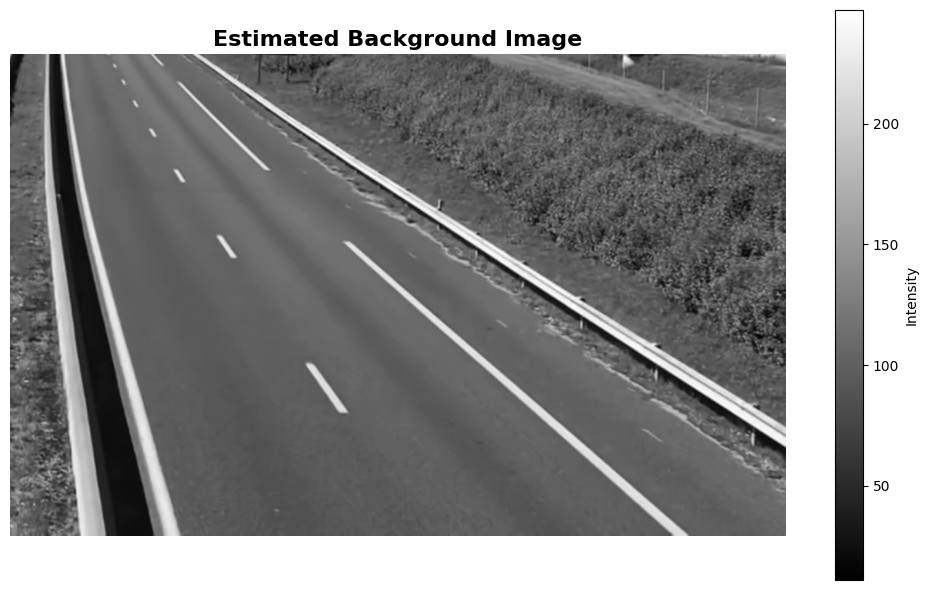


Background image saved as 'estimated_background.png'


In [8]:
print("\n" + "="*60)
print("STEP 1: BACKGROUND ESTIMATION (FROM SCRATCH)")
print("="*60 + "\n")

background = EstimateBackground(grayscale_frames)

print("\nBackground image shape:", background.shape)
print("Background image dtype:", background.dtype)

# Display
plt.figure(figsize=(10, 6))
plt.imshow(background, cmap='gray')
plt.title('Estimated Background Image', fontsize=16, fontweight='bold')
plt.colorbar(label='Intensity')
plt.axis('off')
plt.tight_layout()
plt.show()

# Save
cv2.imwrite('estimated_background.png', background)
print("\nBackground image saved as 'estimated_background.png'")

### Step 2: Detect Motion (From Scratch)

In [9]:
print("\n" + "="*60)
print("STEP 2: MOTION DETECTION (FROM SCRATCH)")
print("="*60 + "\n")

motion_frames = DetectMotion(grayscale_frames, background)

print(f"\nMotion frames shape: {motion_frames.shape}")
print(f"Motion frames dtype: {motion_frames.dtype}")


STEP 2: MOTION DETECTION (FROM SCRATCH)

Detecting motion with threshold=25
Processing 599 frames of size 1128x700...
Using manual operations (from scratch)...
  Processed 50/599 frames
  Processed 100/599 frames
  Processed 150/599 frames
  Processed 200/599 frames
  Processed 250/599 frames
  Processed 300/599 frames
  Processed 350/599 frames
  Processed 400/599 frames
  Processed 450/599 frames
  Processed 500/599 frames
  Processed 550/599 frames
Motion detection complete! Processed 599 frames

Motion frames shape: (700, 1128, 599)
Motion frames dtype: uint8


### Step 3: Save Results


STEP 3: SAVE RESULTS

Saving motion video to motion_detection_output.mp4...
  Written 50/599 frames
  Written 100/599 frames
  Written 150/599 frames
  Written 200/599 frames
  Written 250/599 frames
  Written 300/599 frames
  Written 350/599 frames
  Written 400/599 frames
  Written 450/599 frames
  Written 500/599 frames
  Written 550/599 frames
Motion video saved successfully!


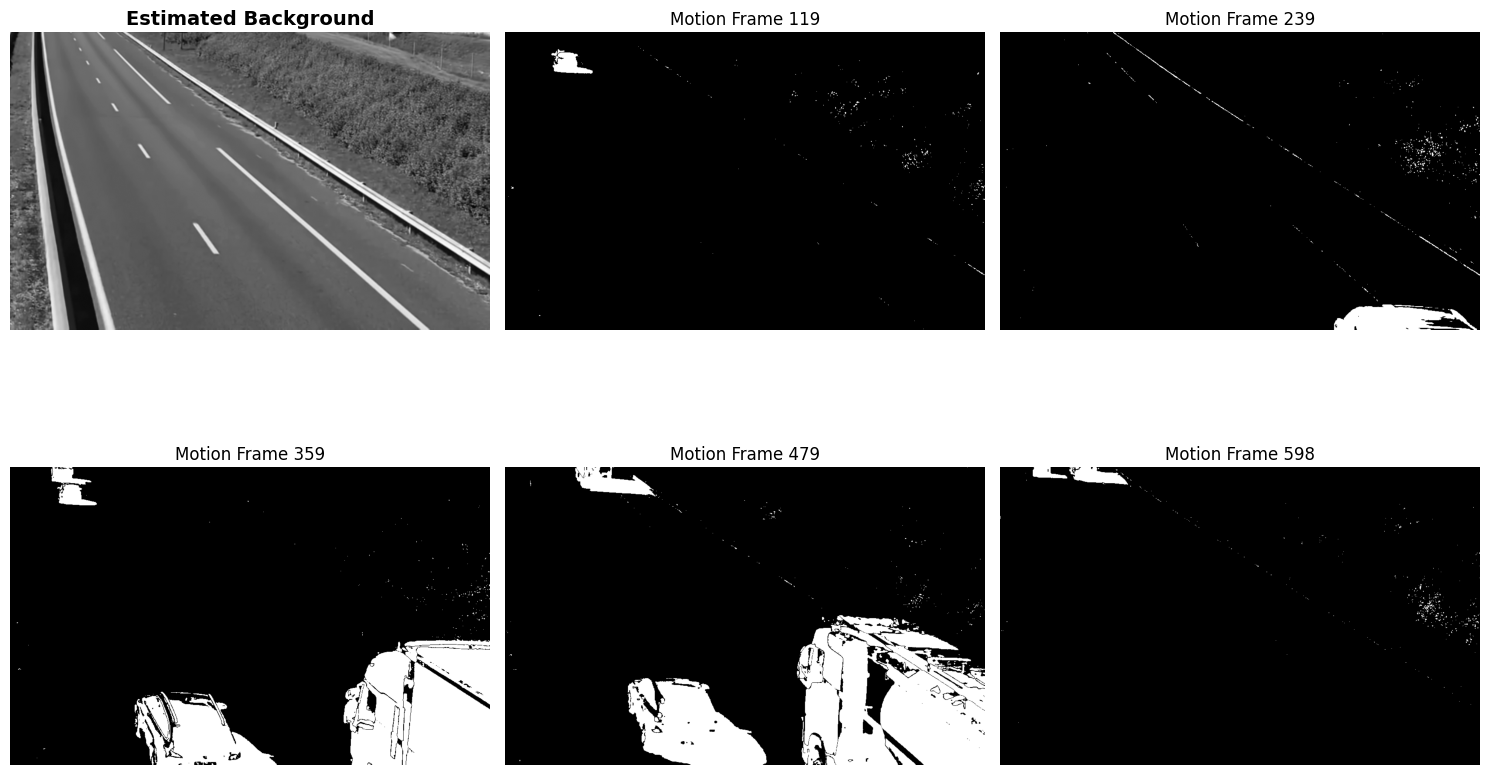

In [10]:
print("\n" + "="*60)
print("STEP 3: SAVE RESULTS")
print("="*60 + "\n")

save_motion_video(motion_frames, output_video_path, fps)

# Display samples
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(background, cmap='gray')
axes[0, 0].set_title('Estimated Background', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

num_frames_total = motion_frames.shape[2]
sample_indices = [num_frames_total // 5, 2 * num_frames_total // 5, 
                  3 * num_frames_total // 5, 4 * num_frames_total // 5, 
                  num_frames_total - 1]

for idx, frame_idx in enumerate(sample_indices):
    row = (idx + 1) // 3
    col = (idx + 1) % 3
    axes[row, col].imshow(motion_frames[:, :, frame_idx], cmap='gray')
    axes[row, col].set_title(f'Motion Frame {frame_idx}', fontsize=12)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### View Videos

In [11]:
print("\n" + "="*60)
print("ORIGINAL VIDEO")
print("="*60)
display(Video(video_path, width=600))


ORIGINAL VIDEO


In [12]:
print("\n" + "="*60)
print("MOTION DETECTION OUTPUT VIDEO")
print("="*60)
display(Video(output_video_path, width=600))


MOTION DETECTION OUTPUT VIDEO
